In [1]:
import numpy as np
import tensorflow as tf
from enum import Enum
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l1_l2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('data/batch1.pkl', 'rb') as f:
    batch1 = np.load(f)
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

with open('data/batch2.pkl', 'rb') as f:
    batch2 = np.load(f)
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]
        
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

with open('data/batch3.pkl', 'rb') as f:
    batch3 = np.load(f)
    
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

batch1_size = len(batch1.keys())
batch2_size = len(batch2.keys())
batch3_size = len(batch3.keys())

batch_size = batch1_size + batch2_size + batch3_size

batches = {**batch1, **batch2, **batch3}

del batch1
del batch2
del batch3

In [3]:
test_ind = np.hstack((np.arange(0,(batch1_size+batch2_size),2),83))
train_ind = np.arange(1,(batch1_size+batch2_size-1),2)
secondary_test_ind = np.arange(batch_size-batch3_size,batch_size)

print('type: ', test_ind.dtype)

type:  int64


Text(0,0.5,'Discharge Capacity (Ah)')

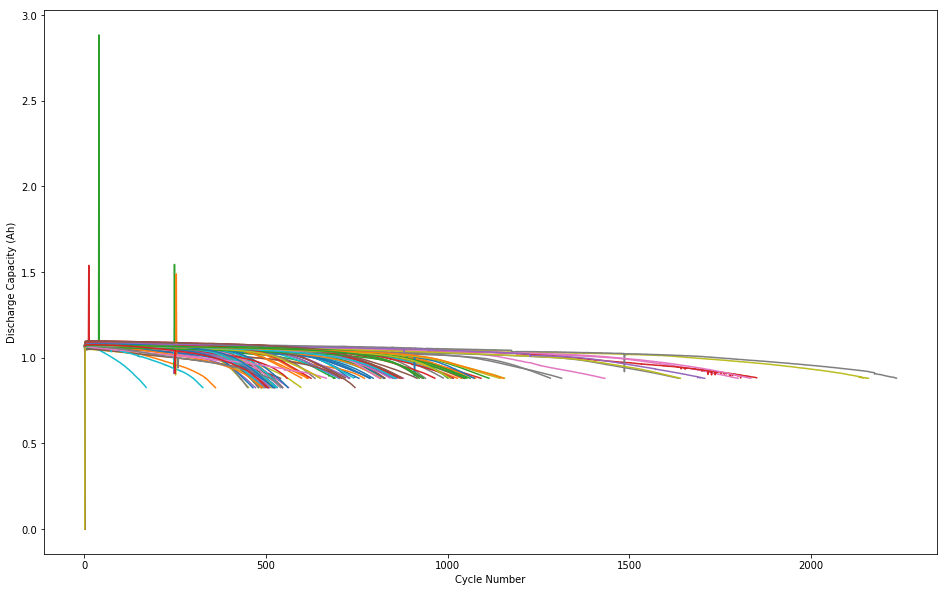

In [4]:
plt.figure(figsize=(16,10))
for i in batches.keys():
    plt.plot(batches[i]['summary']['cycle'], batches[i]['summary']['QD'])
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')

In [5]:
print('Cell count: ', len(batches))
print('Cell names: ', batches.keys())

Cell count:  124
Cell names:  dict_keys(['b2c20', 'b1c45', 'b3c3', 'b3c15', 'b1c11', 'b2c37', 'b1c3', 'b1c35', 'b2c45', 'b1c28', 'b1c33', 'b2c3', 'b3c5', 'b2c29', 'b2c23', 'b2c26', 'b2c17', 'b3c17', 'b2c19', 'b2c1', 'b3c31', 'b3c21', 'b1c18', 'b3c35', 'b2c4', 'b1c29', 'b3c45', 'b3c43', 'b3c34', 'b1c34', 'b2c30', 'b3c26', 'b3c1', 'b2c33', 'b1c32', 'b2c34', 'b1c20', 'b3c25', 'b2c41', 'b1c42', 'b3c24', 'b1c37', 'b2c44', 'b2c5', 'b1c36', 'b3c28', 'b1c14', 'b3c44', 'b1c1', 'b1c23', 'b1c19', 'b3c10', 'b1c25', 'b1c0', 'b1c16', 'b3c8', 'b2c43', 'b1c2', 'b2c38', 'b2c21', 'b3c41', 'b3c9', 'b1c9', 'b1c24', 'b3c14', 'b2c25', 'b3c7', 'b2c46', 'b2c24', 'b2c0', 'b1c5', 'b2c35', 'b2c22', 'b1c30', 'b2c14', 'b3c4', 'b1c27', 'b1c6', 'b2c10', 'b3c13', 'b3c40', 'b1c38', 'b3c22', 'b1c40', 'b1c17', 'b2c47', 'b2c13', 'b3c16', 'b3c42', 'b2c40', 'b2c18', 'b3c11', 'b1c26', 'b1c7', 'b3c27', 'b3c12', 'b2c28', 'b3c33', 'b3c18', 'b2c32', 'b2c36', 'b1c44', 'b1c41', 'b1c21', 'b2c27', 'b1c15', 'b3c20', 'b2c39', 'b3c0',

In [6]:
summary = batches['b1c41']['summary']
summary_keys = summary.keys()
print('keys:', summary_keys)
print('cycle: ', len(summary['QD']))

keys: dict_keys(['cycle', 'QC', 'QD', 'IR', 'chargetime', 'Tmin', 'Tavg', 'Tmax'])
cycle:  1050


In [7]:
# How many cycles to look at?
n_cycles = 100

N_EPOCHS = 100

In [8]:
max_inputs = np.max([[len(cell['cycles'][str(i)]['Qd']) for i in range(n_cycles)] for _,cell in batches.items()])
print('max inputs: ', max_inputs)

max inputs:  31104


In [ ]:
class ModelType(Enum):
    VARIANCE = 0
    DISCHARGE = 1
    FULL = 2

In [ ]:
def get_dataset(d, model_type, n_cycles, n_inputs):
    data = None
    
    if model_type == ModelType.DISCHARGE:
        keys = ['Qd']
    elif model_type == ModelType.FULL:
        keys = next(iter(d.values()))['cycles']['0'].keys()
    else:
        raise NotImplemented('Not yet...')
    n_features = len(keys)

    for name, cell in d.items():
        features = np.zeros(shape=(n_cycles, n_features, n_inputs))
        for i in range(n_cycles):
            cycle = cell['cycles'][str(i)]
            for j, key in enumerate(keys):
                values = cycle[key]
                features[i,j,:len(values)] = values
        features = features.flatten()
        y = len(cell['summary']['cycle'])
        xy = np.array([features, y])
        if data is None:
            data = xy
        else:
            data = np.vstack([data, xy])
    return data

model_type = ModelType.DISCHARGE
data = get_dataset(batches, model_type, n_cycles, max_inputs)

data_train = data[train_ind]
data_val = data[test_ind]
data_test = data[secondary_test_ind]

In [ ]:
data0 = data_train[0]
print('data 0: ',data0)
print('non zero: ', np.count_nonzero(data0[0]))

data 0:  [array([0., 0., 0., ..., 0., 0., 0.]) 598]
non zero:  103127


In [ ]:
'''
Just a simple linear MLP.
'''
class BaselineModel(Model):
    def __init__(self, n_inputs, n_layers=3, n_neurons=64):
        super(BaselineModel, self).__init__()
        
        l1reg = 0.5
        l2reg = (1.0-l1reg)/2
        
        layers = []
        layers.append(Dense(n_neurons, activation='relu', input_shape=(n_inputs,),
                      kernel_regularizer=l1_l2(l1=l1reg, l2=l2reg)))
        for _ in range(n_layers-1):
            layers.append(Dense(n_neurons, activation='relu',
                                kernel_regularizer=l1_l2(l1=l1reg, l2=l2reg)))
        self.hidden_layers = layers
        self.out = Dense(1)

    def call(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        return self.out(x)

model = BaselineModel(max_inputs)

In [ ]:
loss_fn = tf.keras.losses.MeanSquaredError()
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, decay=lr/N_EPOCHS)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_mse = tf.keras.metrics.MeanSquaredError(name='train_mse')
train_mape = tf.keras.metrics.MeanAbsolutePercentageError(name='train_mape')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_mse = tf.keras.metrics.MeanSquaredError(name='test_mse')
test_mape = tf.keras.metrics.MeanAbsolutePercentageError(name='test_mape')

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = loss_fn(y, predictions)
                
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
    train_loss(loss)
    train_mse(y, predictions)
    train_mape(y, predictions)

In [ ]:
@tf.function
def test_step(x, y):
    predictions = model(x)
    loss = loss_fn(y, predictions)
  
    test_loss(loss)
    test_mse(y, predictions)
    test_mape(y, predictions)

In [ ]:
# will be slow unless you're on a GPU :'(
train_rmses, train_mapes, test_rmses, test_mapes = [], [], [], []
for epoch in range(N_EPOCHS):
    
    for x, y in data_train:
        train_step(np.array([x]), np.array([y]))

    for x, y in data_val:
        test_step(np.array([x]), np.array([y]))
        
    train_rmses.append(np.sqrt(train_mse.result()))
    test_rmses.append(np.sqrt(test_mse.result()))
    train_mapes.append(train_mape.result())
    test_mapes.append(test_mape.result())
    template = ('Epoch {}\n'
                'Loss: {}, RMSE: {}\n'
                'Test loss: {}, RMSE: {}, Mean average % error: {}')
    print(template.format(epoch+1,
                         train_loss.result(), 
                         train_rmses[-1],
                         test_loss.result(), 
                         test_rmses[-1],
                         test_mapes[-1]))

Epoch 1
Loss: 296099.34375, RMSE: 544.1500854492188
Test loss: 105188.7890625, RMSE: 324.3282470703125, Mean average % error: 27.38106346130371
Epoch 2
Loss: 222740.484375, RMSE: 471.9538879394531
Test loss: 110470.8359375, RMSE: 332.3715515136719, Mean average % error: 29.862966537475586
Epoch 3
Loss: 196802.609375, RMSE: 443.6243896484375
Test loss: 110204.1328125, RMSE: 331.9700927734375, Mean average % error: 30.64214324951172
Epoch 4
Loss: 179460.65625, RMSE: 423.6279602050781
Test loss: 108568.2578125, RMSE: 329.4969787597656, Mean average % error: 30.36052703857422
Epoch 5
Loss: 167039.609375, RMSE: 408.7048034667969
Test loss: 108318.546875, RMSE: 329.1178283691406, Mean average % error: 30.48086929321289


In [ ]:
plt.figure(figsize=(16,10))
plt.plot(train_rmses, label='RMSE (train)')
plt.plot(test_rmses, label='RMSE (test)')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(test_mapes, label='Mean average % error (test)')
plt.legend()
plt.show()

In [ ]:
for x, y_true in data_val[:10]:
    y_pred = model(np.array([x]))
    plt.scatter(y_true, y_pred)
    plt.ylabel('Cycles (predicted)')
    plt.xlabel('Cycles (true)')